# CC HITChipDB tutorial

Before I begin with the tutorial I use the sample IDs as Gerben selected them for the childcare project. 

In [9]:
library(vegan)
library(microbiome)
library(tidyverse)
library(here)

In [11]:
# load data and helper functions
source(here("R/bayesian_helper.R"))
source(here("R/mb_helper.R"))
load(here("data/data_transfer.RData"))
source(here("R/read.R"))

This is loo version 2.0.0.
**NOTE: As of version 2.0.0 loo defaults to 1 core but we recommend using as many as possible. Use the 'cores' argument or set options(mc.cores = NUM_CORES) for an entire session. Visit mc-stan.org/loo/news for details on other changes.

Attaching package: ‘glue’

The following object is masked from ‘package:SummarizedExperiment’:

    trim

The following object is masked from ‘package:GenomicRanges’:

    trim

The following objects are masked from ‘package:IRanges’:

    collapse, trim

The following object is masked from ‘package:dplyr’:

    collapse



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 10 rows containing non-finite values (stat_bin).”

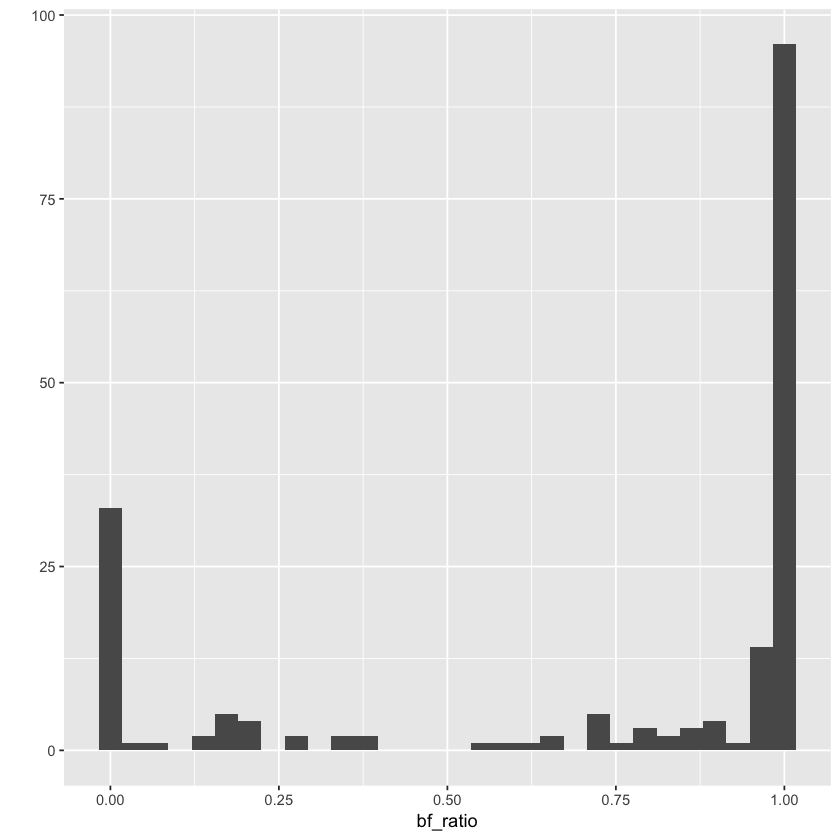

In [12]:
# take over the meta variables I created in other docs
meta_new <- data_transfer[, 1:9] 
# for ordination, I create bf versus no bf
qplot(data = meta_new, bf_ratio)
# based on the plot maybe it is sensible to make 3 categories

In [13]:
# just for handson purposes I create categories from the bf_ratio.
meta_new <- meta_new %>%
  mutate(
      groups = ifelse(time == "pre" & cc == "no", "noCCpre", ifelse(
          time == "pre" & cc == "yes", "CCpre", ifelse(
              time == "post" & cc == "no", "noCCpost", "CCpost"))),
      bf = ifelse(bf_ratio <= 0.25, "lowBF", ifelse(
          bf_ratio <0.75, "mediumBF", "highBF"))) %>% 
  mutate(groups = as.factor(groups), bf = as.factor(bf))

In [14]:
# create new pseq object (from read.R results a pseq object Leo created)
otu <- otu_to_df(genus)
otu <- otu %>% select(species, meta_new$sample_id) %>% df_to_otu()
pseq <- phyloseq(otu, df_to_sd(meta_new), tax_table(genus))

In [15]:
pseq
genus

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 130 taxa and 196 samples ]
sample_data() Sample Data:       [ 196 samples by 10 sample variables ]
tax_table()   Taxonomy Table:    [ 130 taxa by 3 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 130 taxa and 806 samples ]
sample_data() Sample Data:       [ 806 samples by 82 sample variables ]
tax_table()   Taxonomy Table:    [ 130 taxa by 3 taxonomic ranks ]

In [16]:
# add diversity indeces to sample data
diversities <- 
    global(pseq, index = "all") %>% 
    select(contains("diversities")) %>% 
    rownames_to_column("sample_id")
colnames(diversities) <- gsub("diversities_", "", colnames(diversities))

sample_data(pseq) <- 
    sd_to_df(pseq) %>% 
    left_join(diversities, by = "sample_id") %>%
    df_to_sd()

Richness
Observed (richness 0)
Diversity
Evenness
Dominance
Rarity
Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”Warning message:
“Setting row names on a tibble is deprecated.”

# Workflow 

I try to perform some of the analyses of [this tutorial](https://f1000research.com/articles/5-1492/v2) with he childcare hitchip data.

In [17]:
# use relative abundance data
pseq_c <- microbiome::transform(pseq, "compositional") 

## Ordination

# PCoA and MDS

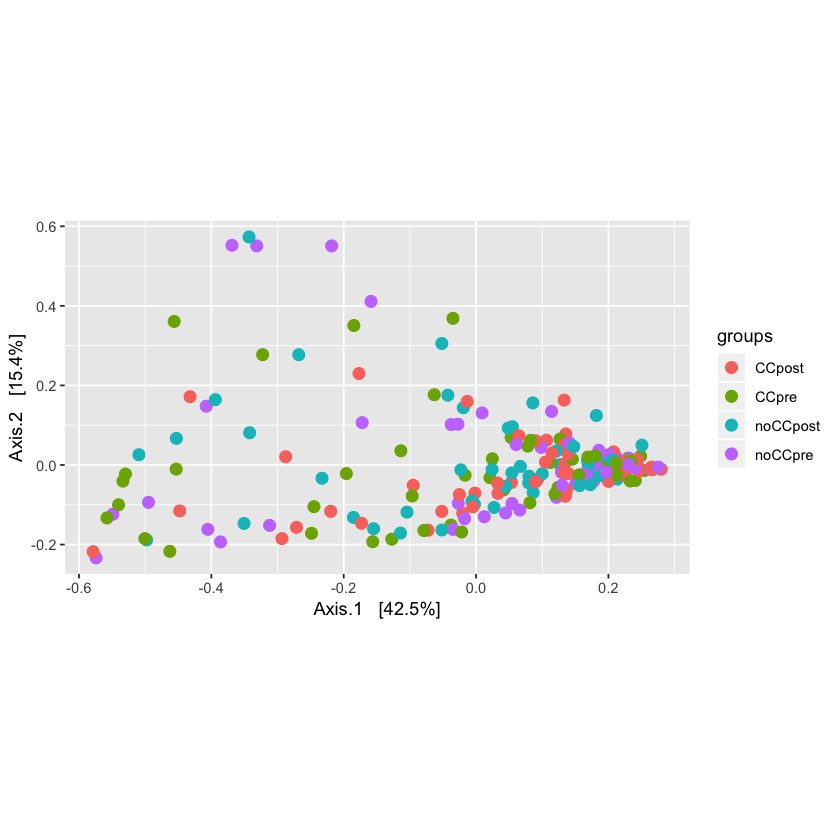

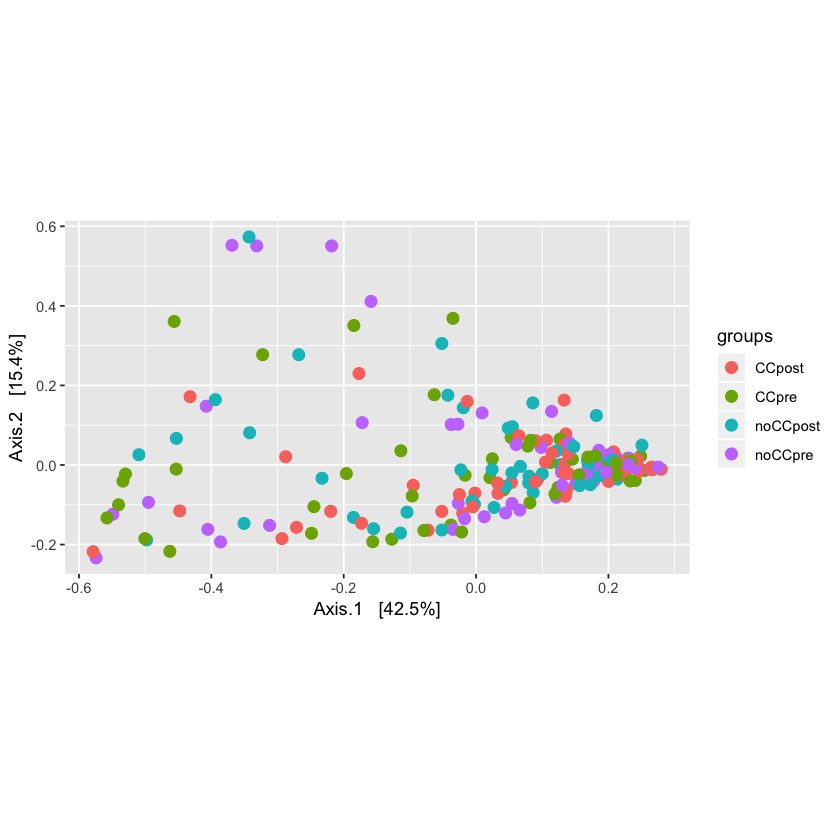

In [18]:
# PCoA bray
cc_pcoa <- ordinate(pseq_c, method = "PCoA", distance = "bray")
e_values <- cc_pcoa$values$Eigenvalues
plot_ordination(pseq_c, cc_pcoa, color = "groups") +
    geom_point(size = 3) +
    coord_fixed(sqrt(e_values[2] / e_values[1]))

# # PCoA weighted unifrac (phy_tree slot is empty)
# cc_pcoa <- ordinate(pseq_c, method = "PCoA", distance = "wunifrac")
# e_values <- cc_pcoa$values$Eigenvalues
# plot_ordination(pseq_c, cc_pcoa, color = "groups") +
#     geom_point(size = 3) +
#     coord_fixed(sqrt(e_values[2] / e_values[1]))


# MDS
cc_mds <- ordinate(pseq_c, "MDS", "bray")
e_values <- cc_mds$values$Eigenvalues
plot_ordination(pseq_c, cc_mds, color = "groups") +
    geom_point(size = 3) +
    coord_fixed(sqrt(e_values[2] / e_values[1]))

## Canocial correspondence analysis

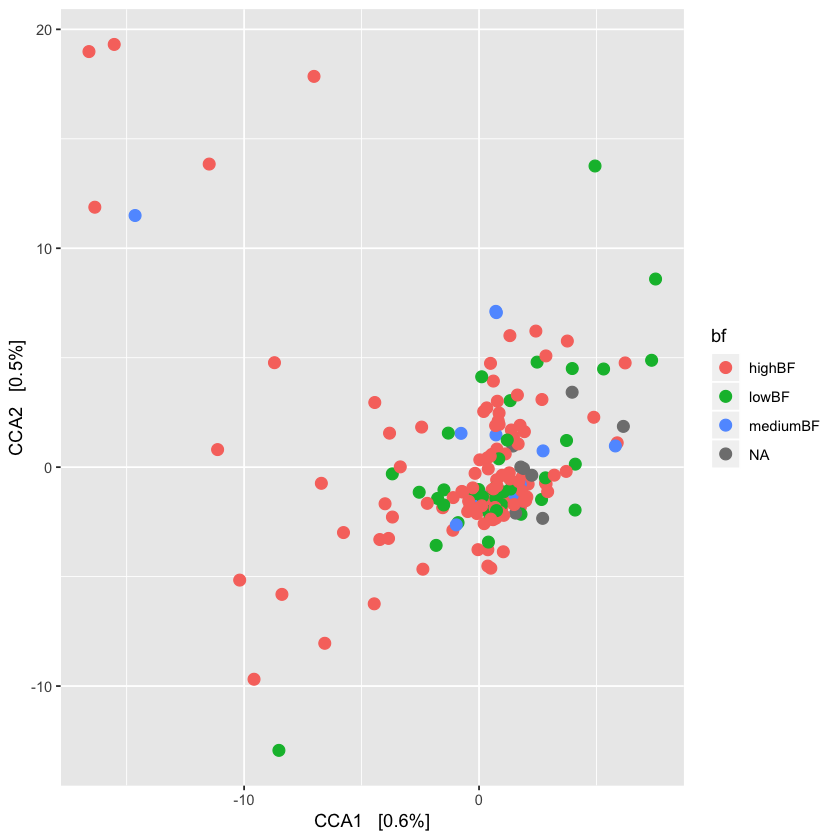

In [19]:
pseq.cca <- ordinate(pseq_c, "CCA", formula = pseq ~ groups)
plot_ordination(pseq_c, pseq.cca, type = "samples", color = "bf") +
  geom_point(size = 3)

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

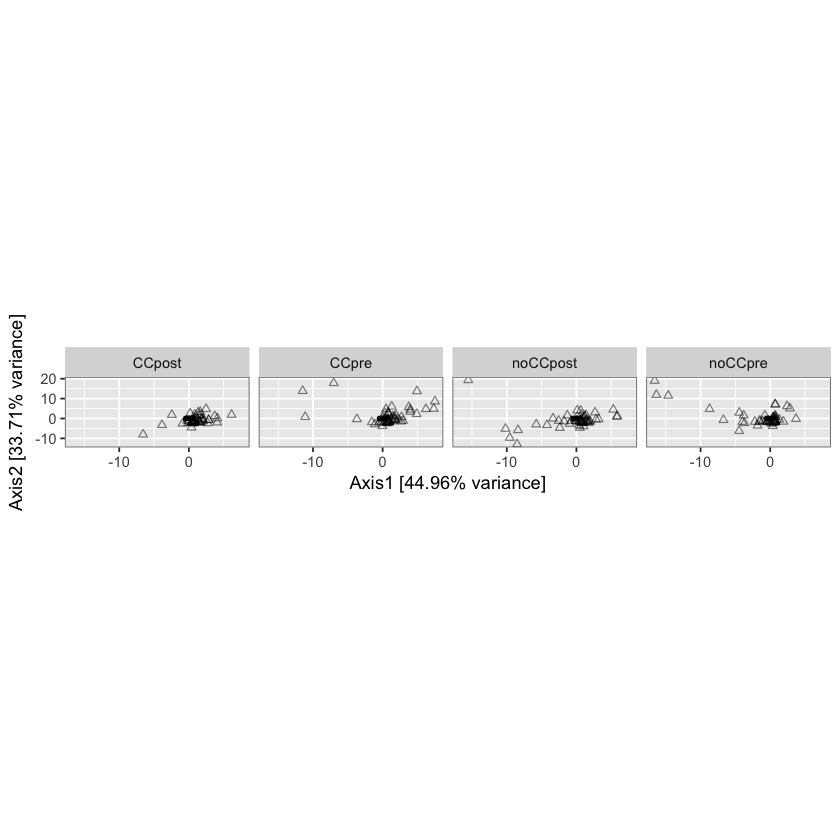

In [20]:
# prepare some objects as in the tutorial for plotting
tax <- 
    tax_table(pseq)@.Data %>% 
        data.frame(stringsAsFactors = FALSE)
ps_scores <- vegan::scores(pseq.cca)
sites <- data.frame(ps_scores$sites)
sites$sample_id <- rownames(sites)
sites <- sites %>%
    left_join(sd_to_df(pseq_c), by = "sample_id")
species <- data.frame(ps_scores$species) %>% 
    rownames_to_column("L2") %>%
    left_join(tax, by = "L2")
species$otu_id <- 1:dim(species)[2]

evals_prop <- 100 * pseq.cca$CCA$eig[1:2] / sum(pseq.cca$CCA$eig)

library(ggrepel)
# 
ggplot() +
    geom_point(data = sites, aes(x = CCA1, y = CCA2), shape = 2, alpha = 0.5) +
    geom_point(data = species, aes(x = CCA1, y = CCA2), size = 0.5) +
    geom_text_repel(data = species %>% filter(CCA2 < -2),
                    aes(x = CCA1, y = CCA2, label = otu_id),
                    size = 1.5, segment.size = 0.1) +
    facet_grid(. ~ groups) +
    guides(col = guide_legend(override.aes = list(size = 3))) +
    labs(x = sprintf("Axis1 [%s%% variance]", round(evals_prop[1], 2)),
         y = sprintf("Axis2 [%s%% variance]", round(evals_prop[2], 2))) +
    scale_color_brewer(palette = "Set2") +
    coord_fixed(sqrt(pseq.cca$CCA$eig[2] / pseq.cca$CCA$eig[1])*0.33) +
    theme(panel.border = element_rect(color = "#787878", fill = alpha("white", 0)))

## Partial Least Squares
_I did not split data into training and testing set_

In [21]:
library(caret)

dataMatrix <- data.frame(groups = sample_data(pseq_c)$groups, t(otu_table(pseq_c)))
pls.fit <- train(groups ~., data = na.omit(dataMatrix), method = "pls", preProc = "center")

Warning message in fitFunc(X, Y, ncomp, Y.add = Y.add, center = center, ...):
“No convergence in 100 iterations
”Warning message in fitFunc(X, Y, ncomp, Y.add = Y.add, center = center, ...):
“No convergence in 100 iterations
”Warning message in fitFunc(X, Y, ncomp, Y.add = Y.add, center = center, ...):
“No convergence in 100 iterations
”

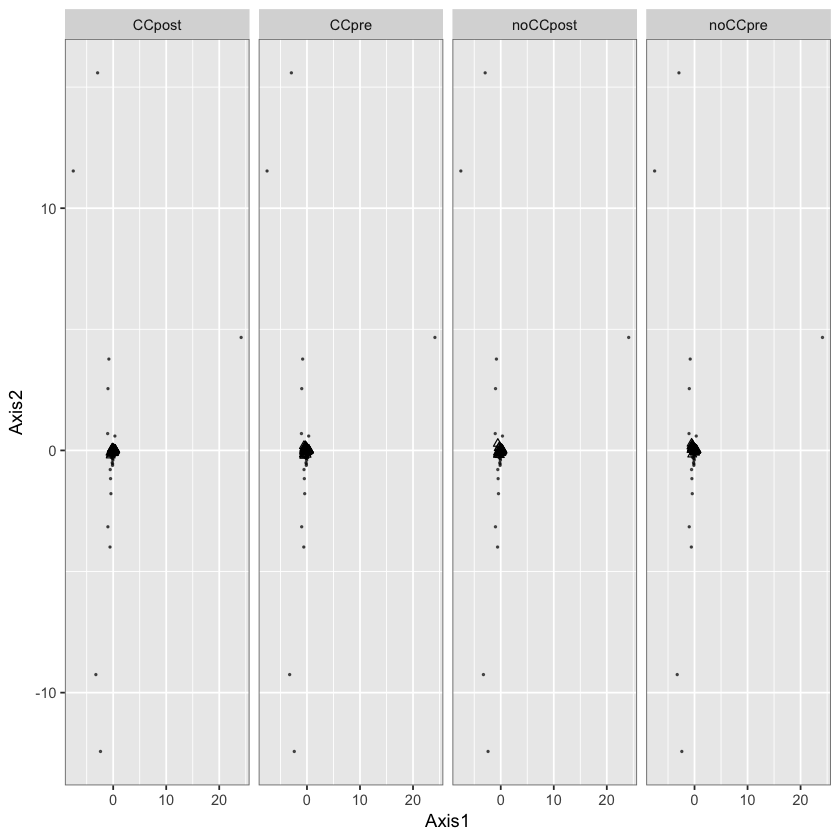

In [22]:
# create biplot for interpretation
pls_biplot <- list("loadings" = loadings(pls.fit$finalModel),
                  "scores" = scores(pls.fit$finalModel))
class(pls_biplot$scores) <- "matrix"
pls_biplot$scores <- data.frame(sample_data(pseq_c), pls_biplot$scores)
tax <- tax_table(pseq)@.Data %>%
    data.frame(stringsAsFactors = FALSE)
class(pls_biplot$loadings) <- "matrix"
pls_biplot$loadings <- data.frame(tax, pls_biplot$loadings)


ggplot() +
    geom_point(data = pls_biplot$scores, 
               aes(x = Comp.1, y = Comp.2), shape = 2) +
    geom_point(data = pls_biplot$loadings,
              aes(x = 25 * Comp.1, y = 25 * Comp.2),
               size = 0.3, alpha = 0.6) +
    scale_color_brewer(palette = "Set2") +
    labs(x = "Axis1", y = "Axis2", col = "bf") +
    guides(col = guide_legend(override.aes = list(size = 3))) +
    facet_grid(~groups) +
    theme(panel.border = element_rect(color = "#787878", fill = alpha("white", 0)))

## Random Forests
_I did not split data into training and testing set and left out the plot for now._

In [23]:
rf.fit <- train(groups ~., data = na.omit(dataMatrix), method = "rf", preProc = "center", proximity = T)
rf.fit

Random Forest 

196 samples
130 predictors
  4 classes: 'CCpost', 'CCpre', 'noCCpost', 'noCCpre' 

Pre-processing: centered (130) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 196, 196, 196, 196, 196, 196, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa     
    2   0.2666342  0.03655080
   66   0.2711200  0.04126920
  130   0.2748252  0.04644803

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 130.

## Mixed Models
In the tutorial, alpha diversity (shannon) is regressed on age etc. 
First some basic plots to visualize what we will quantify:

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

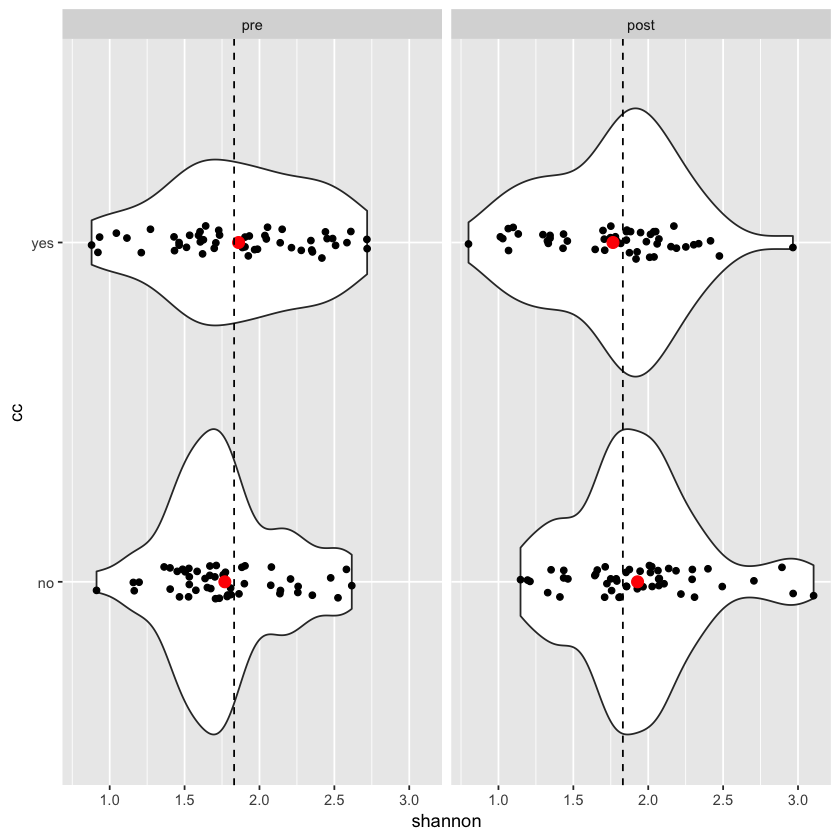

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”Warning message:
“Removed 10 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 10 rows containing missing values (geom_point).”

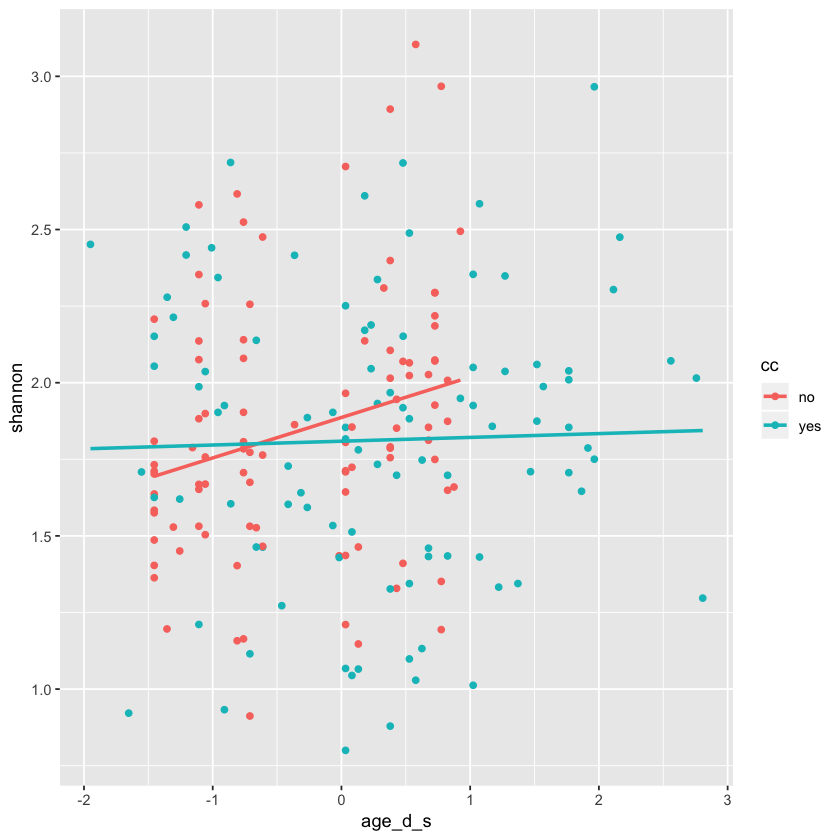

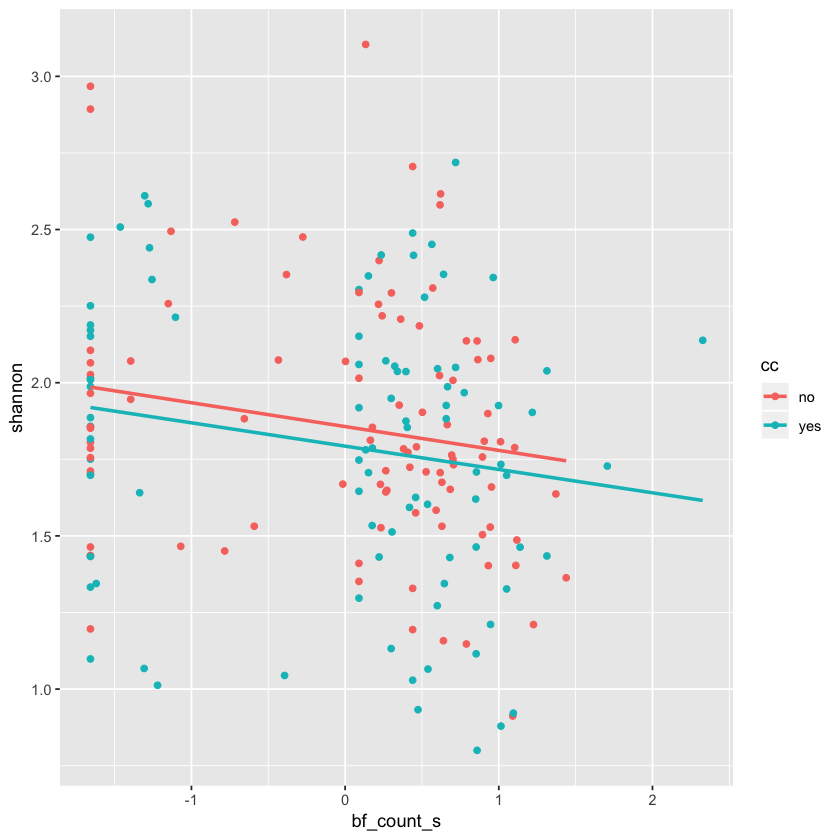

In [24]:
# cc*time vs div
ggplot(sd_to_df(pseq), aes(x = cc, shannon)) +
    geom_violin() +
    geom_jitter(width = 0.05) +
    stat_summary(fun.y = mean, geom = "point", color = "red", size = 3) +
    facet_wrap(.~time) +
    geom_hline(aes(yintercept = mean(shannon)), linetype = "dashed") +
    coord_flip()

# age vs div
ggplot(sd_to_df(pseq), aes(x = age_d_s, shannon, col = cc)) +
    geom_point() +
    geom_smooth(method = "lm", se = F)

# bf vs div
ggplot(sd_to_df(pseq), aes(x = bf_count_s, shannon, col = cc)) +
    geom_point() +
    geom_smooth(method = "lm", se = F)

In [25]:
library(afex)

df <- sd_to_df(pseq)
# check contrasts for interpretation
contrasts(df$cc)
contrasts(df$time)

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”

,yes
no,0
yes,1


,post
pre,0
post,1


In [26]:
# mixed function in afex uses contr.sum
mfit <- mixed(shannon ~ cc*time + age_d_s  + (1|subject_id),
            data = df, method = "KR")
# output
mfit$anova_table
summary(mfit)

Contrasts set to contr.sum for the following variables: cc, time


Fitting one lmer() model. [DONE]
Calculating p-values. [DONE]


,num Df,den Df,F,Pr(>F)
cc,1,95.41076,1.274510,0.261752790
time,1,138.38139,1.346225,0.247936937
age_d_s,1,97.22048,2.622551,0.108594451
cc:time,1,96.13783,8.217148,0.005098495


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: shannon ~ cc * time + age_d_s + (1 | subject_id)
   Data: data

REML criterion at convergence: 227.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.16772 -0.41328 -0.02524  0.56992  2.51456 

Random effects:
 Groups     Name        Variance Std.Dev.
 subject_id (Intercept) 0.09115  0.3019  
 Residual               0.10091  0.3177  
Number of obs: 196, groups:  subject_id, 98

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   1.83069    0.03801  95.00228  48.160   <2e-16 ***
cc1           0.04759    0.04215  95.41291   1.129   0.2617    
time1         0.06125    0.05277 138.38311   1.161   0.2478    
age_d_s       0.10320    0.06370  97.22263   1.620   0.1084    
cc1:time1    -0.06507    0.02270  96.13997  -2.867   0.0051 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
       

In [27]:
# alternatively we can use lme4
lme4.fit <- lme4::lmer(shannon ~ cc*time + age_d_s  + (1|subject_id),
            data = df)
summary(lme4.fit)
car::Anova(lme4.fit, test = "F", type = 2)

Linear mixed model fit by REML ['lmerMod']
Formula: shannon ~ cc * time + age_d_s + (1 | subject_id)
   Data: df

REML criterion at convergence: 221.8

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.16772 -0.41328 -0.02524  0.56992  2.51456 

Random effects:
 Groups     Name        Variance Std.Dev.
 subject_id (Intercept) 0.09115  0.3019  
 Residual               0.10091  0.3177  
Number of obs: 196, groups:  subject_id, 98

Fixed effects:
                Estimate Std. Error t value
(Intercept)     1.874464   0.090389  20.738
ccyes           0.034960   0.095244   0.367
timepost        0.007631   0.113794   0.067
age_d_s         0.103200   0.063696   1.620
ccyes:timepost -0.260278   0.090798  -2.867

Correlation of Fixed Effects:
            (Intr) ccyes  timpst ag_d_s
ccyes       -0.721                     
timepost    -0.796  0.494              
age_d_s      0.721 -0.369 -0.826       
ccyes:tmpst  0.230 -0.466 -0.375 -0.029

,F,Df,Df.res,Pr(>F)
cc,1.194559,1,95.44034,0.277162920
time,1.177867,1,138.58165,0.279674946
age_d_s,2.622551,1,97.22048,0.108594451
cc:time,8.217148,1,96.13783,0.005098495


In [28]:
newdata <- select(df, subject_id, cc, time, age_d_s)
newdata$pred <- predict(lme4.fit, newdata = newdata)

## DESeq2

In [29]:
library(DESeq2)
# how to avoid NA formation here??
# ok it seems that the following is the problem:
# R is restricted to integers that are smaller than 2147483648. 
# therefore I apply disvision by 1000, then it works
pseq2 <- pseq
otu_table(pseq2) <- otu_table(pseq2)/1000
ds2 <- phyloseq_to_deseq2(pseq2, ~ time + cc + time:cc + (1|subject_id))

converting counts to integer mode
the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function


ERROR: Error in checkFullRank(modelMatrix): the model matrix is not full rank, so the model cannot be fit as specified.
  One or more variables or interaction terms in the design formula are linear
  combinations of the others and must be removed.

  Please read the vignette section 'Model matrix not full rank':

  vignette('DESeq2')


In [ ]:
varianceStabilizingTransformation(ds2, blind = TRUE, fitType = "parametric")

In [ ]:
ds2 <- estimateSizeFactors(ds2)
ds2 <- estimateDispersions(ds2)
abund <- getVarianceStabilizedData(ds2)

In [ ]:
dds <- DESeq(ds2)
res <- results(dds) %>% 
    as.data.frame() %>%
    rownames_to_column("taxon") %>%
    arrange(padj, log2FoldChange)



In [ ]:
res

In [ ]:
# Running the DESeq2 analysis
ds2 <- phyloseq_to_deseq2(pseq, ~ nationality)
dds <- DESeq(ds2)
res <- results(dds)
df <- as.data.frame(res)
df$taxon <- rownames(df)
df <- df %>% arrange(log2FoldChange, padj)

## TSNE (microbiome tutorial)

_the tutorial would ocntinue with network analysis and more but I will first check univariate analysis now_

In [ ]:
library(Rtsne)

method <- "tsne"
trans <- "hellinger"
distance <- "euclidean"
ps <- microbiome::transform(pseq_c, trans)
dm <- vegdist(otu_table(ps), distance)
tsne_out <- Rtsne(dm, dims = 2)
proj <- tsne_out$Y
rownames(proj) <- rownames(otu_table(ps))
plot_landscape(proj, legend = T, size = 1)

In [77]:
pseq.clr <- microbiome::transform(pseq, transform = "clr")
pseq.log <- microbiome::transform(pseq, transform = "log10")

In [116]:
# compare distributions of log10 and clr transformed data
otus.clr <- otu_to_df(pseq.clr)
otus.clr <- 
    otus.clr %>% gather(sample, value, -species) %>%
        spread(species, value) %>%
        select(-sample) 
colnames(otus.clr) <- gsub(" ", "_", colnames(otus.clr))
colnames(otus.clr)[which(colnames(otus.clr) == "Clostridium_\\(sensu_stricto\\)")] <- "Clostridium_sensu_stricto"

otus.log <- otu_to_df(pseq.log)
otus.log <- 
    otus.log %>% gather(sample, value, -species) %>%
        spread(species, value) %>%
        select(-sample) 
colnames(otus.log) <- gsub(" ", "_", colnames(otus.log))
colnames(otus.log)[which(colnames(otus.log) == "Clostridium_\\(sensu_stricto\\)")] <- "Clostridium_sensu_stricto"

# lapply(colnames(otus.clr), function(x) {
#     df <- tibble(clr = otus.clr[, x], log = otus.log[, x])
#     p <- 
#         df %>% gather(transformation, value) %>%
#             ggplot(aes(value)) +
#                 geom_density() +
#                 facet_wrap(~transformation, scales = "free") +
#                 ggtitle(x)
# })

In [101]:
meta <- sd_to_df(pseq.clr)
adonis(otus.clr ~ cc*time, data = meta)

Warning message in class(x) <- c(subclass, "tbl_df", "tbl", "data.frame"):
“Setting class(x) to multiple strings ("tbl_df", "tbl", ...); result will no longer be an S4 object”Warning message in vegdist(lhs, method = method, ...):
“you have empty rows: their dissimilarities may be meaningless in method “bray””Warning message in vegdist(lhs, method = method, ...):
“results may be meaningless because data have negative entries in method “bray””


Call:
adonis(formula = otus.clr ~ cc * time, data = meta) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model R2 Pr(>F)
cc          1                                    
time        1                                    
cc:time     1                                    
Residuals 192                                    
Total     195                                    

In [99]:
adonis(otus.log ~ cc*time, data = meta)


Call:
adonis(formula = otus.log ~ cc * time, data = meta) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs    MeanSqs F.Model      R2 Pr(>F)  
cc          1 0.0000328 3.2846e-05 0.66584 0.00341  0.718  
time        1 0.0000991 9.9082e-05 2.00855 0.01028  0.056 .
cc:time     1 0.0000309 3.0886e-05 0.62611 0.00321  0.763  
Residuals 192 0.0094714 4.9330e-05         0.98310         
Total     195 0.0096342                    1.00000         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [111]:
adonis(t(otu_to_df(pseq)) ~ cc*time, data = meta)

ERROR: Error in vegdist(lhs, method = method, ...): input data must be numeric


In [115]:
t(otu_to_df(pseq))[, ]

species,Actinomycetaceae,Bifidobacterium,Collinsella,Corynebacterium,Eggerthella lenta et rel.,Micrococcaceae,Propionibacterium,Asteroleplasma et rel.,Aerococcus,Aneurinibacillus,⋯,Serratia,Sutterella wadsworthia et rel.,Vibrio,Xanthomonadaceae,Yersinia et rel.,Brachyspira,Uncultured Clostridiales I,Uncultured Clostridiales II,Uncultured Mollicutes,Akkermansia
sa_10000,95437960,64158389352,22641631109,116190411,590304295,34271169,106086843,34160794,34418017,34496048,⋯,35758965,400707385,214058584,78167545,139606447,68949643,1090034889,941458676,488276804,124457684
sa_10038,70285829,73431020743,273467820,106004289,291873663,46642350,100560763,33233109,58269597,33686188,⋯,42188583,341028088,137103444,73531177,138918441,66923027,1014275146,900874779,470740026,2434091796
sa_10118,74484694,86306076271,703964240,110052264,227924989,34888306,160524141,34399154,35926703,34472173,⋯,514368080,363275597,148666406,80899448,142086614,68844384,1043195095,902706698,484267265,75223793
sa_10211,75817084,90635946592,185152153,109874467,222059099,36982838,108222295,33314736,40500380,34292289,⋯,36265188,348161507,136693850,78164036,139786725,67804613,1039314499,900511407,484153950,76117117
sa_10230,91935475,265358404178,675684172,136734691,260252083,43466178,121367855,34939244,38836478,35147940,⋯,53529146,376524199,143278640,81956231,142512907,70058307,1070584645,914030167,496845916,82247157
sa_10247,178938899,428466459752,299489076,196504905,427190715,45453118,248881464,46245333,43452277,44387712,⋯,44738684,549849711,250728719,139111372,205028979,84456382,1354187082,1161864913,625353895,111273107
sa_1025,95024228,305117805616,251132574,142617569,426313104,51115357,283357034,39193171,58976548,38809695,⋯,40249116,446307977,172897303,109982054,170637236,76189168,1172657716,1036651078,543901079,90876508
sa_10268,75928422,2250223981,243965506,135161828,257683189,99111567,278077999,40058557,107254417,40092152,⋯,2016047008,839191594,338021867,619147173,9133514874,74025379,1142432986,1190035229,536109949,74936224
sa_1028,75284821,120046030594,193724940,117378886,245150250,45885946,102449777,33106695,58713341,33368936,⋯,649352571,379809882,152729171,86689510,418162626,66145518,1005758558,905002926,469196308,112557642
sa_1030,74363557,216173847405,196213536,116875345,242069566,52589614,118406476,33416244,65196122,33386644,⋯,33336631,382696470,138168658,94254358,140187357,66699155,1019548236,1027522017,473565724,78931757
